# Script para calcular el missing money para un escenario 

Llamar las librerías

In [187]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

Definición de colores

In [188]:
tech_colors = {
    'Bomb': 'blue',
    'CAES': 'purple',
    'CSP-TES': 'orange',
    'ESS': 'hotpink',
    'HYDRO': 'deepskyblue',
    'PV': 'yellow',
    'TERMO': 'brown',
    'TES': 'red',
    'WIND': 'green',
}

Definición de diccionarios

In [189]:
#[$/kW/mes]

map_pncp_bar_loadzone_bar = {
    "loschangos": "CALAMA",
    "nuevapozoalmonte": "TARAPACA",
    "parinacota": "PARINACOTA",
    "lagunas": "TARAPACA",
    "arica": "PARINACOTA",
    "tarapaca": "TARAPACA",
    "coquimbo": "PANDEAZUCAR",
    "atacama": "ATACAMA",
    "valparaiso": "QUILLOTA",
}

PNCP_jul_24={
    "PARINACOTA":9307.94, #Arica
    "POZOALMONTE":8980.87,
    "CONDORES":9035.92,
    "TARAPACA":8860.24, #Tarapaca
    "LAGUNAS":8785.75,
    "NUEVAVICTORIA":8750.94,
    "CRUCERO":8447.34,
    "ENCUENTRO":8465.96,
    "CHUQUICAMATA":8508.06,
    "CALAMA":8517.78,
    "ELTESORO":8479.73,
    "ESPERANZASING":8478.11,
    "ATACAMA":8329.14,
    "ELCOBRE":8402.00,
    "LABERINTO":8444.10,
    "OHIGGINS":8457.06,
    "DDEALMAGRO":8372.05,
    "CARRERAPINTO":8307.28,
    "CARDONES":8267.61,
    "MAITENCILLO":8044.97,
    "PUNTACOLORADA":8030.40,
    "PANDEAZUCAR":8134.84,
    "LOSVILOS":8058.74,
    "NOGALES":8095.98,
    "QUILLOTA":8016.64,
    "POLPAICO":8018.26,
    "ELLLANO":8054.69,
    "LOSMAQUIS":8075.74,
    "LAMPA":7734.90,
    "CERRONAVIA":8039.31,
    "MELIPILLA":7994.78,
    "RAPEL":7907.34,
    "CHENA":8030.40,
    "MAIPO":7875.77,
    "ALTOJAHUEL":7879.81,
    "ITAHUE":7075.07,
    "ANCOA":6974.68,
    "CHARRUA":6782.81,
    "COLBUN":6974.68,
    "CANDELARIA":7735.71,
    "HUALPEN":7014.35,
    "LAGUNILLAS":7009.50,
    "CAUTÍN":5983.74,
    "TEMUCO":6000.74,
    "CIRUELOS":7981.04,
    "VALDIVIA":7925.62,
    "RAHUE":7536.97,
    "PUERTOMONTT":7590.87,
    "MELIPULLI":7590.87,
    "CHILOE":7676.64,
}

potencia_recocida = {
    1: 0.36,
    2: 0.65,
    3: 0.85,
    4: 0.98,
    5: 1.00,
}

Definición de url

In [190]:
use_monthly_aggregation = False #True, lo divide en meses, False, lo deja anual
time_key_for_plot = 'month' if use_monthly_aggregation == True else 'year'
discount_rate = 0.07

# base_route = "C:\Users\maty_\Desktop\Magister\Tesis\Scripts"
base_route = "C:/Users/Ignac/Trabajo_Centra/Catedra-LDES/CII-Centra-EDF/Operacion"
# study_case = "Modelos_SEN_finals/EEN 1 EEC 1 (Transicion Acelerada)"
study_case = "escenarios/CaseBase1/CN"
# study_case = "Modelos_SEN_finals/EEN -1 EEC -1 (Recuperacion Lenta)"
inputs_path = "inputs_opp"
outputs_path = "outputs"

periods = [2029, 2030, 2031, 2033, 2040, 2050]

technologies_interest = ["Bomb", "CSP-TES", "TES", "CAES"]

Lectura de archivos consolidados de resultados

In [191]:
# Cada consolidado de resultados corresponde a un year tipo para su periodo correspondiente, por lo que no es necesario escalar mas que por la cantidad de years

period_results = []
for period in periods:
    file_path = fr'{base_route}\{study_case}\{outputs_path}\battery_operational_results_{period}.csv'
    base_data = pd.read_csv(file_path)
    base_data["PERIOD"] = period
    period_results.append(base_data)
data = pd.concat(period_results, ignore_index=True)
file_path_periods = fr'{base_route}\{study_case}\{inputs_path}\periods.csv'
periods_data = pd.read_csv(file_path_periods)
file_path_gen_build_costs = fr'{base_route}\{study_case}\{inputs_path}\gen_build_costs.csv'
gen_build_costs_data = pd.read_csv(file_path_gen_build_costs)
file_path_gen_build = fr'{base_route}\{study_case}\{outputs_path}\gen_build.csv'
gen_build_data = pd.read_csv(file_path_gen_build)
file_path_gen_cap = fr'{base_route}\{study_case}\{outputs_path}\gen_cap.csv'
gen_cap_data = pd.read_csv(file_path_gen_cap)
file_path_gen_info = fr'{base_route}\{study_case}\{inputs_path}\gen_info.csv'
gen_info_data = pd.read_csv(file_path_gen_info)
gen_info_data

,GENERATION_PROJECT,gen_tech,gen_load_zone,gen_connect_cost_per_mw,gen_capacity_limit_mw,gen_full_load_heat_rate,gen_variable_om,gen_max_age,gen_min_build_capacity,gen_scheduled_outage_rate,...,gen_tes_powerblock_eff,gen_tes_duration,gen_can_provide_cap_reserves,csp_tes_capacity_upper_mwht,csp_sf_tes_efficiency,csp_tes_efficiency,csp_tes_pb_efficiency,csp_sf_tes_pb_efficiency,csp_pb_efficiency,peak_demand_gen_max_percent
0,Ancali1,TERMO,Gxnode-Ancali1-Bio Bio_2,0.0,1.56,1.992,0.000,70,0,0.000000,...,.,.,0,.,.,.,.,.,.,0.78
1,Copiulemu,TERMO,Gxnode-Copiulemu-Bio Bio_2,0.0,0.99,0.243,25.200,70,0,0.000000,...,.,.,0,.,.,.,.,.,.,0.78
2,ElCampesino,TERMO,Gxnode-ElCampesino-Metropolitana de Santiago_2,0.0,1.59,1.992,22.786,70,0,0.000000,...,.,.,0,.,.,.,.,.,.,0.78
3,ElMolle,TERMO,Gxnode-ElMolle-Valparaiso,0.0,4.50,0.25,18.197,70,0,0.000000,...,.,.,0,.,.,.,.,.,.,0.78
4,HBS,TERMO,Gxnode-HBS-Bio Bio_2,0.0,2.20,0.26,6.940,70,0,0.000000,...,.,.,0,.,.,.,.,.,.,0.78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1502,BESS Víctor Jara,ESS,Tarapaca_2,0.0,200.00,.,0.000,30,0,0.032877,...,.,.,5,.,.,.,.,.,.,1.00
1503,BESS Huatacondo,ESS,Tarapaca,0.0,98.00,.,0.000,30,0,0.032877,...,.,.,1,.,.,.,.,.,.,0.81
1504,BESS Livorno,ESS,Valparaiso,0.0,5.00,.,0.000,30,0,0.032877,...,.,.,5,.,.,.,.,.,.,1.00
1505,BESS San Marcos,ESS,Arica y Parinacota,0.0,2.90,.,0.000,30,0,0.032877,...,.,.,1,.,.,.,.,.,.,0.81


Trabajo sobre dataframe periods_data

In [192]:
periods_data["period_duration_years"] = periods_data["period_end"] - periods_data["period_start"]
periods_data = periods_data.rename(columns={"INVESTMENT_PERIOD": "PERIOD"})
periods_data

,PERIOD,period_start,period_end,period_duration_years
0,2024,2024,2026,2
1,2026,2026,2029,3
2,2029,2029,2030,1
3,2030,2030,2031,1
4,2031,2031,2033,2
5,2033,2033,2040,7
6,2040,2040,2050,10
7,2050,2050,2060,10


Filtrado de dataframes filtered_cost, filtered_gen_build y filtered_gen_cap

In [193]:
# Step 2: Filter by the specific project
generation_projects_of_interest = list(set(data["generation_project"]))
# project_name = "Bomb_Tarapaca2_10h"
# filtered_data = data[data['generation_project'] == project_name].copy()
filtered_cost = gen_build_costs_data[(gen_build_costs_data["gen_overnight_cost"] != 0)].copy()
filtered_cost = filtered_cost.rename(columns={"build_year": "PERIOD"})
filtered_gen_build = gen_build_data[gen_build_data["GENERATION_PROJECT"].isin(generation_projects_of_interest)].copy()
filteder_gen_cap = gen_cap_data[gen_cap_data["GENERATION_PROJECT"].isin(generation_projects_of_interest)][["GENERATION_PROJECT", "PERIOD", "GenCapacity"]].copy()
filteder_gen_cap

,GENERATION_PROJECT,PERIOD,GenCapacity
80,ANDES IV SOLAR FOTOVOLTAICO BESS,2024,0.000
81,ANDES IV SOLAR FOTOVOLTAICO BESS,2026,130.000
82,ANDES IV SOLAR FOTOVOLTAICO BESS,2029,130.000
83,ANDES IV SOLAR FOTOVOLTAICO BESS,2030,130.000
84,ANDES IV SOLAR FOTOVOLTAICO BESS,2031,130.000
...,...,...,...
11435,TES_Parinacota220_250_6h,2030,0.000
11436,TES_Parinacota220_250_6h,2031,0.000
11437,TES_Parinacota220_250_6h,2033,0.000
11438,TES_Parinacota220_250_6h,2040,0.000


Ajuste para proyectos TES

In [194]:
#Ajuste para proyectos TES que tienen duracion en columna distinta
gen_info_data.loc[gen_info_data['gen_tech'] == 'TES', 'gen_storage_energy_to_power_ratio'] = gen_info_data['gen_tes_duration']
gen_info_data_filtered = gen_info_data[["GENERATION_PROJECT", "gen_storage_energy_to_power_ratio", "gen_tech"]][gen_info_data["GENERATION_PROJECT"].isin(generation_projects_of_interest)].copy()
gen_info_data_filtered["power_recognized"] = gen_info_data_filtered.apply(lambda row: potencia_recocida.get(int(row['gen_storage_energy_to_power_ratio']), 1), axis=1).fillna(1).astype(float)
gen_info_data_filtered = gen_info_data_filtered.rename(columns={"GENERATION_PROJECT": "generation_project"})

Calculo CAPEX y OPEX

In [195]:
df_merge_cost_build = pd.merge(filtered_gen_build, filtered_cost, on=['GENERATION_PROJECT','PERIOD'], how='inner', suffixes=('_df1', '_df2'))
# df_merge_cost_build = pd.merge(df_merge_cost_build, periods_data, on='PERIOD', how='inner', suffixes=('_df1', '_df2'))
df_merge_cost_build = pd.merge(df_merge_cost_build, filteder_gen_cap, on=['GENERATION_PROJECT','PERIOD'], how='inner', suffixes=('_df1', '_df2'))

df_merge_cost_build["capex"] = df_merge_cost_build["BuildGen"].astype(float)*df_merge_cost_build["gen_overnight_cost"].astype(float)
#Fixed operation and maintenance costs per MW of capacity per year
df_merge_cost_build["opex"] = df_merge_cost_build["GenCapacity"].astype(float)*df_merge_cost_build["gen_fixed_om"].astype(float)


# df_consolidated_opex_capex_period = df_merge_cost_build[["PERIOD", "capex", "opex"]].copy()
consolidated_capex_cost_period_dict = df_merge_cost_build.set_index(['GENERATION_PROJECT','PERIOD'])["capex"].to_dict()
consolidated_opex_cost_period_dict = df_merge_cost_build.set_index(['GENERATION_PROJECT','PERIOD'])["opex"].to_dict()
consolidated_opex_cost_period_dict

{('Bomb_Arica_8h', 2029): 481415.61600000004,
 ('Bomb_Arica_8h', 2030): 481415.61600000004,
 ('Bomb_Arica_8h', 2031): 481415.61600000004,
 ('Bomb_Arica_8h', 2033): 481415.61600000004,
 ('Bomb_Arica_8h', 2040): 481415.61600000004,
 ('Bomb_Arica_8h', 2050): 481415.61600000004,
 ('Bomb_Atacama2_10h', 2029): 0.0,
 ('Bomb_Atacama2_10h', 2030): 361370.8595,
 ('Bomb_Atacama2_10h', 2031): 361370.8595,
 ('Bomb_Atacama2_10h', 2033): 361370.8595,
 ('Bomb_Atacama2_10h', 2040): 361370.8595,
 ('Bomb_Atacama2_10h', 2050): 361370.8595,
 ('Bomb_Atacama_10h', 2029): 0.0,
 ('Bomb_Atacama_10h', 2030): 0.0,
 ('Bomb_Atacama_10h', 2031): 0.0,
 ('Bomb_Atacama_10h', 2033): 0.0,
 ('Bomb_Atacama_10h', 2040): 0.0,
 ('Bomb_Atacama_10h', 2050): 584241.469,
 ('Bomb_Coquimbo_10h', 2029): 1060128.328,
 ('Bomb_Coquimbo_10h', 2030): 1389903.6620000002,
 ('Bomb_Coquimbo_10h', 2031): 1389903.6620000002,
 ('Bomb_Coquimbo_10h', 2033): 1759527.1400000001,
 ('Bomb_Coquimbo_10h', 2040): 1759527.1400000001,
 ('Bomb_Coquimbo_10h

Expansión de periods_data

In [196]:
df_periods_expanded = periods_data.loc[periods_data.index.repeat(periods_data['period_duration_years'])].reset_index(drop=True)
df_periods_expanded['year'] = df_periods_expanded['period_start'] + df_periods_expanded.groupby('period_start').cumcount()
df_periods_expanded

,PERIOD,period_start,period_end,period_duration_years,year
0,2024,2024,2026,2,2024
1,2024,2024,2026,2,2025
2,2026,2026,2029,3,2026
3,2026,2026,2029,3,2027
4,2026,2026,2029,3,2028
5,2029,2029,2030,1,2029
6,2030,2030,2031,1,2030
7,2031,2031,2033,2,2031
8,2031,2031,2033,2,2032
9,2033,2033,2040,7,2033


Join con periods_data

In [197]:
df_expanded_periods = pd.merge(
    data,
    df_periods_expanded[['period_start', 'year']],
    left_on='PERIOD',
    right_on='period_start',
    how='inner'
)
# df_expanded_periods['year'] = df_expanded_periods['year_y']
# df_expanded_periods['month'] = df_expanded_periods.apply(lambda row: pd.Period(year=row['year'], month=row['month'].month, freq='M'), axis=1)
# df_expanded_periods = df_expanded_periods.rename(columns={'year_x': 'PERIOD'})
df_expanded_periods = df_expanded_periods.drop(columns=['period_start']).sort_values(['year']).reset_index(drop=True)

df_expanded_periods = pd.merge(df_expanded_periods, periods_data, left_on="PERIOD", right_on="PERIOD", how="inner")


df_expanded_periods

,generation_project,total_charge_cost,total_discharge_earnings,PERIOD,year,period_start,period_end,period_duration_years
0,ANDES IV SOLAR FOTOVOLTAICO BESS,5.786500e+06,1.668248e+07,2029,2029,2029,2030,1
1,BESS San Andrés,1.594621e+06,4.815385e+06,2029,2029,2029,2030,1
2,BESS San Marcos,6.281442e+04,1.192276e+05,2029,2029,2029,2030,1
3,BESS Tamaya,2.707318e+06,9.266030e+06,2029,2029,2029,2030,1
4,BESS Tocopilla,4.338687e+06,1.388637e+07,2029,2029,2029,2030,1
...,...,...,...,...,...,...,...,...
1634,BESS Diego de Almagro Sur,5.557537e+05,1.145622e+06,2050,2059,2050,2060,10
1635,BESS Quillahua,1.766973e+06,3.621846e+06,2050,2059,2050,2060,10
1636,PFV Salvador,3.596441e+06,8.141629e+06,2050,2059,2050,2060,10
1637,BESS Coya,6.160335e+06,1.862399e+07,2050,2059,2050,2060,10


Trabajo previo a plot

In [198]:
aggregated_data = df_expanded_periods.groupby(["generation_project", time_key_for_plot]).agg({
    'PERIOD': 'max',
    'total_discharge_earnings': 'sum',
    'total_charge_cost': 'sum'
}).reset_index()

Se agregan luego los costos de OPEX y CAPEX para cada periodo

In [199]:
# aggregated_data["capex"] = aggregated_data["year"].map(consolidated_capex_cost_period_dict).fillna(0).astype(float)
# aggregated_data["opex"] = aggregated_data["PERIOD"].map(consolidated_opex_cost_period_dict).fillna(0).astype(float)
filteder_gen_cap = filteder_gen_cap.rename(columns={"GENERATION_PROJECT": "generation_project"})
aggregated_data = pd.merge(aggregated_data, filteder_gen_cap, on=['generation_project','PERIOD'], how='inner')
aggregated_data["capex"] = aggregated_data.apply(lambda row: consolidated_capex_cost_period_dict.get((row['generation_project'], row['year']), None), axis=1).fillna(0).astype(float)
aggregated_data["opex"] = aggregated_data.apply(lambda row: consolidated_opex_cost_period_dict.get((row['generation_project'], row['PERIOD']), None), axis=1).fillna(0).astype(float)
aggregated_data = pd.merge(aggregated_data, gen_info_data_filtered, on="generation_project", how="inner")

def map_bar_and_value(row):
    for keyword, bar_name in map_pncp_bar_loadzone_bar.items():
        if keyword in row['generation_project'].lower():
            return pd.Series({'bar_name': bar_name, 'pnpc_power_value': PNCP_jul_24.get(bar_name, PNCP_jul_24["NOGALES"])})
    return pd.Series({'bar_name': "NOGALES", 'pnpc_power_value': PNCP_jul_24["NOGALES"]})

aggregated_data[['bar_name', 'pnpc_power_value']] = aggregated_data.apply(map_bar_and_value, axis=1)

aggregated_data["yearly_power_income"] = aggregated_data["GenCapacity"]*aggregated_data["power_recognized"]*aggregated_data["pnpc_power_value"]*12

aggregated_data = aggregated_data[["generation_project", time_key_for_plot, "bar_name", "gen_tech", "gen_storage_energy_to_power_ratio", "total_discharge_earnings", "total_charge_cost", "capex", "opex", "yearly_power_income"]].copy()
aggregated_data[aggregated_data["gen_tech"] == "ESS"]

,generation_project,year,bar_name,gen_tech,gen_storage_energy_to_power_ratio,total_discharge_earnings,total_charge_cost,capex,opex,yearly_power_income
0,ANDES IV SOLAR FOTOVOLTAICO BESS,2029,NOGALES,ESS,5,1.668248e+07,5.786500e+06,0.0,0.0,1.262973e+07
1,ANDES IV SOLAR FOTOVOLTAICO BESS,2030,NOGALES,ESS,5,1.841846e+07,5.281661e+06,0.0,0.0,1.262973e+07
2,ANDES IV SOLAR FOTOVOLTAICO BESS,2031,NOGALES,ESS,5,1.935992e+07,3.870860e+06,0.0,0.0,1.262973e+07
3,ANDES IV SOLAR FOTOVOLTAICO BESS,2032,NOGALES,ESS,5,1.935992e+07,3.870860e+06,0.0,0.0,1.262973e+07
4,ANDES IV SOLAR FOTOVOLTAICO BESS,2033,NOGALES,ESS,5,1.996074e+07,5.300682e+06,0.0,0.0,1.262973e+07
...,...,...,...,...,...,...,...,...,...,...
1594,Stand Alone VR1 y VR2,2055,NOGALES,ESS,1,2.476736e+06,1.252612e+06,0.0,0.0,2.098478e+06
1595,Stand Alone VR1 y VR2,2056,NOGALES,ESS,1,2.476736e+06,1.252612e+06,0.0,0.0,2.098478e+06
1596,Stand Alone VR1 y VR2,2057,NOGALES,ESS,1,2.476736e+06,1.252612e+06,0.0,0.0,2.098478e+06
1597,Stand Alone VR1 y VR2,2058,NOGALES,ESS,1,2.476736e+06,1.252612e+06,0.0,0.0,2.098478e+06


Se recuperan los proyectos que hayan sido construidos en el ultimo periodo

In [200]:
# Se recuperan los proyectos que hayan sido construidos en el ultimo periodo
projects_to_replicate = aggregated_data.groupby('generation_project')['year'].min()
projects_to_replicate = projects_to_replicate[projects_to_replicate == 2050].index
rows_to_replicate = aggregated_data[aggregated_data['generation_project'].isin(projects_to_replicate) & (aggregated_data['year'] >= 2050) & (aggregated_data['year'] <= 2059)]
#Se crean las filas repetidas del analisis y se deja el capex en 0 al no haber construccion
replicated_rows = rows_to_replicate.copy()
replicated_rows['year'] += 10
replicated_rows['capex'] = 0.0
# Step 4: Append replicated rows to the original DataFrame
aggregated_data = pd.concat([aggregated_data, replicated_rows], ignore_index=True)

cash_flows calculos

In [201]:
aggregated_data["cash_flow"] = aggregated_data["yearly_power_income"] + aggregated_data['total_discharge_earnings'] - aggregated_data['total_charge_cost'] - aggregated_data["capex"] - aggregated_data["opex"]
aggregated_data["energy_cash_flow"] = aggregated_data['total_discharge_earnings'] - aggregated_data['total_charge_cost']

npv_results = []
# Se generan los VPN por energia y potencia, asi como el total
for project, group in aggregated_data.groupby('generation_project'):
    group = group.sort_values('year')
    base_year = group['year'].iloc[0]  # First year for the project
    group['discounted_cash_flow_energy'] = group['energy_cash_flow'] / ((1 + discount_rate) ** (group['year'] - base_year))
    group['discounted_cash_flow_power'] = group['yearly_power_income'] / ((1 + discount_rate) ** (group['year'] - base_year))
    group['discounted_cash_flow_capex'] = -group['capex'] / ((1 + discount_rate) ** (group['year'] - base_year))
    group['discounted_cash_flow_opex'] = -group['opex'] / ((1 + discount_rate) ** (group['year'] - base_year))
    group['discounted_cash_flow'] = group['cash_flow'] / ((1 + discount_rate) ** (group['year'] - base_year))
    npv = group['discounted_cash_flow'].sum()
    npv_results.append({
        "generation_project": project,
        "NPV": npv,
        "NPV_energy": group['discounted_cash_flow_energy'].sum(),
        "NPV_power": group['discounted_cash_flow_power'].sum(),
        "NPV_capex": group['discounted_cash_flow_capex'].sum(),
        "NPV_opex": group['discounted_cash_flow_opex'].sum(),
        "duration": group["gen_storage_energy_to_power_ratio"].astype(int).max(),
        "tech": group["gen_tech"].iloc[0],
        "base_year": base_year})

# Step 3: Create a DataFrame for plotting
npv_df = pd.DataFrame(npv_results)
npv_df_duration = npv_df.sort_values(by=['duration', 'NPV'], ascending=[True, False]).copy()
npv_df_tech = npv_df[npv_df["tech"].isin(technologies_interest)].sort_values(by=['tech', 'NPV'], ascending=[True, False]).copy()
npv_df_tech_dur = npv_df[npv_df["tech"].isin(technologies_interest)].sort_values(by=['duration',  'tech', 'NPV'], ascending=[True, True, False]).copy()

Trabajo sobre npv_df_duration

In [202]:
npv_df_duration['base_discount_year'] = 2024

for index, row in npv_df_duration.iterrows():
    base_year = row['base_year']
    discount_year = row['base_discount_year']
    years_diff =  base_year - discount_year

    # Factor de descuento
    discount_factor = (1 + discount_rate) ** years_diff

    # Actualizar las columnas NPV, NPV_energy, NPV_power, NPV_capex, NPV_opex
    npv_df_duration.loc[index, 'NPV'] = row['NPV'] / discount_factor
    npv_df_duration.loc[index, 'NPV_energy'] = row['NPV_energy'] / discount_factor
    npv_df_duration.loc[index, 'NPV_power'] = row['NPV_power'] / discount_factor
    npv_df_duration.loc[index, 'NPV_capex'] = row['NPV_capex'] / discount_factor
    npv_df_duration.loc[index, 'NPV_opex'] = row['NPV_opex'] / discount_factor

npv_df_duration = npv_df_duration.sort_values(by=['duration', 'NPV'], ascending=[True, False]).copy()
    
npv_df_duration

,generation_project,NPV,NPV_energy,NPV_power,NPV_capex,NPV_opex,duration,tech,base_year,base_discount_year
10,BESS Gabriela,1.270700e+08,5.350779e+07,7.356220e+07,0.000000e+00,0.000000e+00,1,ESS,2029,2024
27,BESS Víctor Jara,1.190559e+08,5.218122e+07,6.687472e+07,0.000000e+00,0.000000e+00,1,ESS,2029,2024
57,Parque Andes Solar III,9.908503e+07,4.190714e+07,5.717789e+07,0.000000e+00,0.000000e+00,1,ESS,2029,2024
13,BESS Luz del Norte,8.476685e+07,3.762017e+07,4.714668e+07,0.000000e+00,0.000000e+00,1,ESS,2029,2024
4,BESS Bolero,8.463554e+07,3.581699e+07,4.881855e+07,0.000000e+00,0.000000e+00,1,ESS,2029,2024
...,...,...,...,...,...,...,...,...,...,...
32,Bomb_Coquimbo_10h,4.121115e+08,5.945476e+08,3.666076e+08,-5.302998e+08,-1.874385e+07,10,Bomb,2029,2024
33,Bomb_Tarapaca2_10h,1.704789e+08,1.984178e+08,1.287563e+08,-1.506511e+08,-6.044069e+06,10,Bomb,2029,2024
30,Bomb_Atacama2_10h,8.392797e+07,1.033697e+08,6.402746e+07,-8.027199e+07,-3.197220e+06,10,Bomb,2030,2024
36,Bomb_Valparaiso_10h,4.196946e+07,6.448617e+07,3.898114e+07,-5.947544e+07,-2.022407e+06,10,Bomb,2050,2024


Trabajo sobre npv_df_tech_dur

In [203]:
npv_df_tech_dur['base_discount_year'] = 2024

for index, row in npv_df_tech_dur.iterrows():
    base_year = row['base_year']
    discount_year = row['base_discount_year']
    years_diff =  base_year - discount_year

    # Factor de descuento
    discount_factor = (1 + discount_rate) ** years_diff

    # Actualizar las columnas NPV, NPV_energy, NPV_power, NPV_capex, NPV_opex
    npv_df_tech_dur.loc[index, 'NPV'] = row['NPV'] / discount_factor
    npv_df_tech_dur.loc[index, 'NPV_energy'] = row['NPV_energy'] / discount_factor
    npv_df_tech_dur.loc[index, 'NPV_power'] = row['NPV_power'] / discount_factor
    npv_df_tech_dur.loc[index, 'NPV_capex'] = row['NPV_capex'] / discount_factor
    npv_df_tech_dur.loc[index, 'NPV_opex'] = row['NPV_opex'] / discount_factor

npv_df_tech_dur = npv_df_tech_dur.sort_values(by=['duration',  'tech', 'NPV'], ascending=[True, True, False]).copy()
    
npv_df_tech_dur

,generation_project,NPV,NPV_energy,NPV_power,NPV_capex,NPV_opex,duration,tech,base_year,base_discount_year
61,TES_LosChangos220_250_6h,5.727811e+07,6.912584e+07,4.987855e+07,-5.544152e+07,-6.284754e+06,6,TES,2050,2024
63,TES_Parinacota220_250_6h,3.278338e+07,3.667965e+07,2.941099e+07,-2.991602e+07,-3.391228e+06,6,TES,2050,2024
62,TES_NuevaPozoAlmonte220_250_6h,3.206666e+07,3.756577e+07,2.898859e+07,-3.097629e+07,-3.511418e+06,6,TES,2050,2024
60,TES_Lagunas220_250_6h,8.664270e+06,1.011370e+07,7.640676e+06,-8.164585e+06,-9.255230e+05,6,TES,2050,2024
29,Bomb_Arica_8h,1.459737e+08,1.558949e+08,1.091010e+08,-1.144196e+08,-4.602555e+06,8,Bomb,2029,2024
34,Bomb_Tarapaca2_8h,1.259764e+07,1.397385e+07,9.422285e+06,-1.038093e+07,-4.175753e+05,8,Bomb,2029,2024
35,Bomb_Tarapaca_10h,5.145261e+08,6.043715e+08,3.967282e+08,-4.679503e+08,-1.862318e+07,10,Bomb,2029,2024
32,Bomb_Coquimbo_10h,4.121115e+08,5.945476e+08,3.666076e+08,-5.302998e+08,-1.874385e+07,10,Bomb,2029,2024
33,Bomb_Tarapaca2_10h,1.704789e+08,1.984178e+08,1.287563e+08,-1.506511e+08,-6.044069e+06,10,Bomb,2029,2024
30,Bomb_Atacama2_10h,8.392797e+07,1.033697e+08,6.402746e+07,-8.027199e+07,-3.197220e+06,10,Bomb,2030,2024


Trabajo sobre npv_df_tech

In [204]:
npv_df_tech['base_discount_year'] = 2024

for index, row in npv_df_tech.iterrows():
    base_year = row['base_year']
    discount_year = row['base_discount_year']
    years_diff =  base_year - discount_year

    # Factor de descuento
    discount_factor = (1 + discount_rate) ** years_diff

    # Actualizar las columnas NPV, NPV_energy, NPV_power, NPV_capex, NPV_opex
    npv_df_tech.loc[index, 'NPV'] = row['NPV'] / discount_factor
    npv_df_tech.loc[index, 'NPV_energy'] = row['NPV_energy'] / discount_factor
    npv_df_tech.loc[index, 'NPV_power'] = row['NPV_power'] / discount_factor
    npv_df_tech.loc[index, 'NPV_capex'] = row['NPV_capex'] / discount_factor
    npv_df_tech.loc[index, 'NPV_opex'] = row['NPV_opex'] / discount_factor

npv_df_tech = npv_df_tech.sort_values(by=['tech', 'NPV'], ascending=[True, False]).copy()
    
npv_df_tech

,generation_project,NPV,NPV_energy,NPV_power,NPV_capex,NPV_opex,duration,tech,base_year,base_discount_year
35,Bomb_Tarapaca_10h,5.145261e+08,6.043715e+08,3.967282e+08,-4.679503e+08,-1.862318e+07,10,Bomb,2029,2024
32,Bomb_Coquimbo_10h,4.121115e+08,5.945476e+08,3.666076e+08,-5.302998e+08,-1.874385e+07,10,Bomb,2029,2024
33,Bomb_Tarapaca2_10h,1.704789e+08,1.984178e+08,1.287563e+08,-1.506511e+08,-6.044069e+06,10,Bomb,2029,2024
29,Bomb_Arica_8h,1.459737e+08,1.558949e+08,1.091010e+08,-1.144196e+08,-4.602555e+06,8,Bomb,2029,2024
30,Bomb_Atacama2_10h,8.392797e+07,1.033697e+08,6.402746e+07,-8.027199e+07,-3.197220e+06,10,Bomb,2030,2024
36,Bomb_Valparaiso_10h,4.196946e+07,6.448617e+07,3.898114e+07,-5.947544e+07,-2.022407e+06,10,Bomb,2050,2024
31,Bomb_Atacama_10h,2.184112e+07,3.368110e+07,2.283770e+07,-3.353727e+07,-1.140403e+06,10,Bomb,2050,2024
34,Bomb_Tarapaca2_8h,1.259764e+07,1.397385e+07,9.422285e+06,-1.038093e+07,-4.175753e+05,8,Bomb,2029,2024
61,TES_LosChangos220_250_6h,5.727811e+07,6.912584e+07,4.987855e+07,-5.544152e+07,-6.284754e+06,6,TES,2050,2024
63,TES_Parinacota220_250_6h,3.278338e+07,3.667965e+07,2.941099e+07,-2.991602e+07,-3.391228e+06,6,TES,2050,2024


Calcula vpn con periodo inicial al año 2024

In [205]:
npv_df_LDES = npv_df[npv_df["tech"].isin(technologies_interest)]

npv_df_LDES['base_discount_year'] = 2024

for index, row in npv_df_LDES.iterrows():
    base_year = row['base_year']
    discount_year = row['base_discount_year']
    years_diff =  base_year - discount_year

    # Factor de descuento
    discount_factor = (1 + discount_rate) ** years_diff

    # Actualizar las columnas NPV, NPV_energy, NPV_power, NPV_capex, NPV_opex
    npv_df_LDES.loc[index, 'NPV'] = row['NPV'] / discount_factor
    npv_df_LDES.loc[index, 'NPV_energy'] = row['NPV_energy'] / discount_factor
    npv_df_LDES.loc[index, 'NPV_power'] = row['NPV_power'] / discount_factor
    npv_df_LDES.loc[index, 'NPV_capex'] = row['NPV_capex'] / discount_factor
    npv_df_LDES.loc[index, 'NPV_opex'] = row['NPV_opex'] / discount_factor

npv_df_LDES = npv_df_LDES.sort_values(by=['duration', 'NPV'], ascending=[True, False]).copy()

npv_df_LDES

C:\Users\Ignac\AppData\Local\Temp\ipykernel_17480\4147383802.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  npv_df_LDES['base_discount_year'] = 2024


,generation_project,NPV,NPV_energy,NPV_power,NPV_capex,NPV_opex,duration,tech,base_year,base_discount_year
61,TES_LosChangos220_250_6h,5.727811e+07,6.912584e+07,4.987855e+07,-5.544152e+07,-6.284754e+06,6,TES,2050,2024
63,TES_Parinacota220_250_6h,3.278338e+07,3.667965e+07,2.941099e+07,-2.991602e+07,-3.391228e+06,6,TES,2050,2024
62,TES_NuevaPozoAlmonte220_250_6h,3.206666e+07,3.756577e+07,2.898859e+07,-3.097629e+07,-3.511418e+06,6,TES,2050,2024
60,TES_Lagunas220_250_6h,8.664270e+06,1.011370e+07,7.640676e+06,-8.164585e+06,-9.255230e+05,6,TES,2050,2024
29,Bomb_Arica_8h,1.459737e+08,1.558949e+08,1.091010e+08,-1.144196e+08,-4.602555e+06,8,Bomb,2029,2024
34,Bomb_Tarapaca2_8h,1.259764e+07,1.397385e+07,9.422285e+06,-1.038093e+07,-4.175753e+05,8,Bomb,2029,2024
35,Bomb_Tarapaca_10h,5.145261e+08,6.043715e+08,3.967282e+08,-4.679503e+08,-1.862318e+07,10,Bomb,2029,2024
32,Bomb_Coquimbo_10h,4.121115e+08,5.945476e+08,3.666076e+08,-5.302998e+08,-1.874385e+07,10,Bomb,2029,2024
33,Bomb_Tarapaca2_10h,1.704789e+08,1.984178e+08,1.287563e+08,-1.506511e+08,-6.044069e+06,10,Bomb,2029,2024
30,Bomb_Atacama2_10h,8.392797e+07,1.033697e+08,6.402746e+07,-8.027199e+07,-3.197220e+06,10,Bomb,2030,2024


In [206]:
total_npv = npv_df_LDES['NPV'].sum()
total_npv

1534218880.8633642

Gráficos

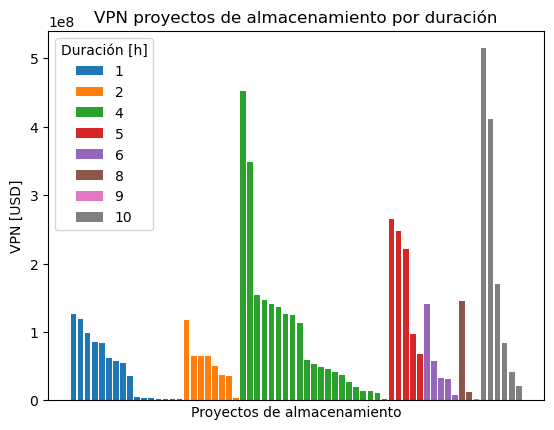

In [207]:
for category, group in npv_df_duration.groupby("duration"):
    plt.bar(
        group["generation_project"],  # X-axis
        group["NPV"],  # Y-axis
        label=category  # Legend label
    )

# Add labels and legend
plt.xticks([])
plt.xlabel("Proyectos de almacenamiento")
plt.ylabel("VPN [USD]")
plt.title("VPN proyectos de almacenamiento por duración")
plt.legend(title="Duración [h]")
plt.show()

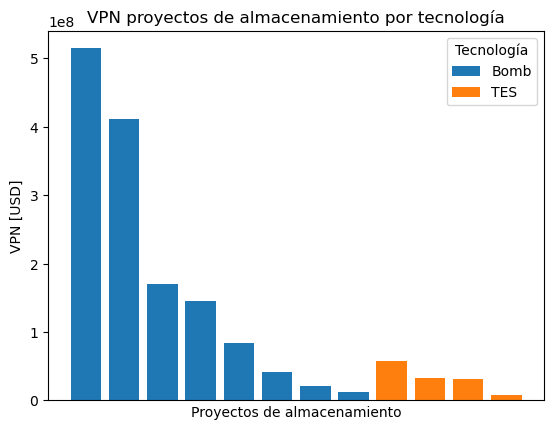

In [208]:
for category, group in npv_df_tech.groupby("tech"):
    plt.bar(
        group["generation_project"],  # X-axis
        group["NPV"],  # Y-axis
        label=category  # Legend label
    )

# Add labels and legend
plt.xticks([])
plt.xlabel("Proyectos de almacenamiento")
plt.ylabel("VPN [USD]")
plt.title("VPN proyectos de almacenamiento por tecnología")
plt.legend(title="Tecnología")
plt.show()

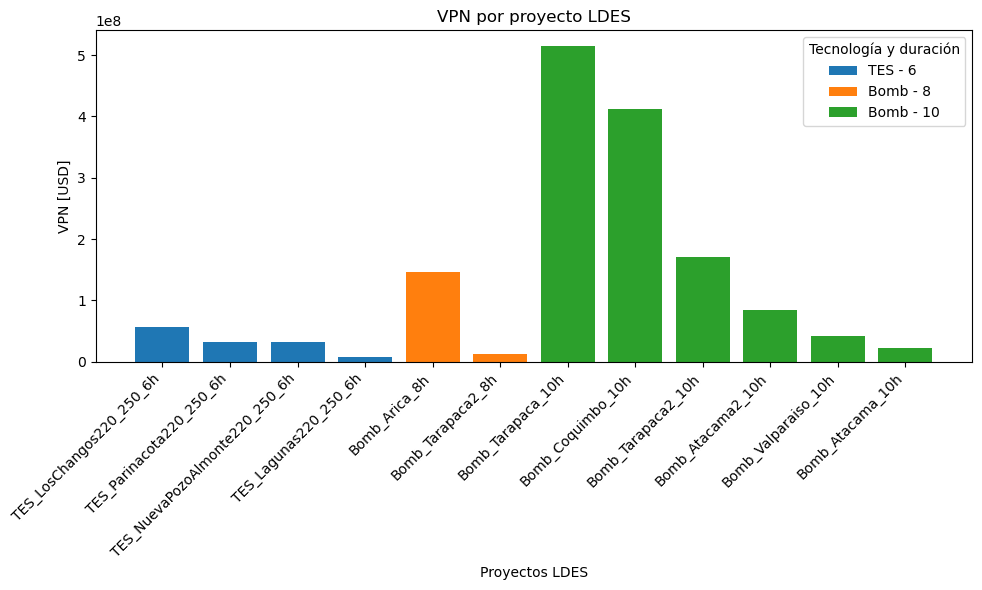

In [209]:
npv_df_tech_dur["group"] = list(zip(npv_df_tech_dur["tech"], npv_df_tech_dur["duration"]))
colors = {group: color for group, color in zip(npv_df_tech_dur["group"].unique(), plt.cm.tab10.colors)}

# Plot each row
fig, ax = plt.subplots(figsize=(10, 6))
for _, row in npv_df_tech_dur.iterrows():
    ax.bar(
        row["generation_project"],  # X-axis
        # row["NPV"],
        row["NPV_energy"] + row["NPV_power"] + row["NPV_capex"] + row["NPV_opex"],  # Y-axis
        color=colors[row["group"]],  # Color based on group
        label=f"{row["group"][0]} - {row["group"][1]}" if f"{row["group"][0]} - {row["group"][1]}" not in ax.get_legend_handles_labels()[1] else ""
    )

# Customize plot
ax.set_xlabel("Proyectos LDES")
ax.set_ylabel("VPN [USD]")
ax.set_title("VPN por proyecto LDES")
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better readability
plt.legend(title="Tecnología y duración")
plt.tight_layout()

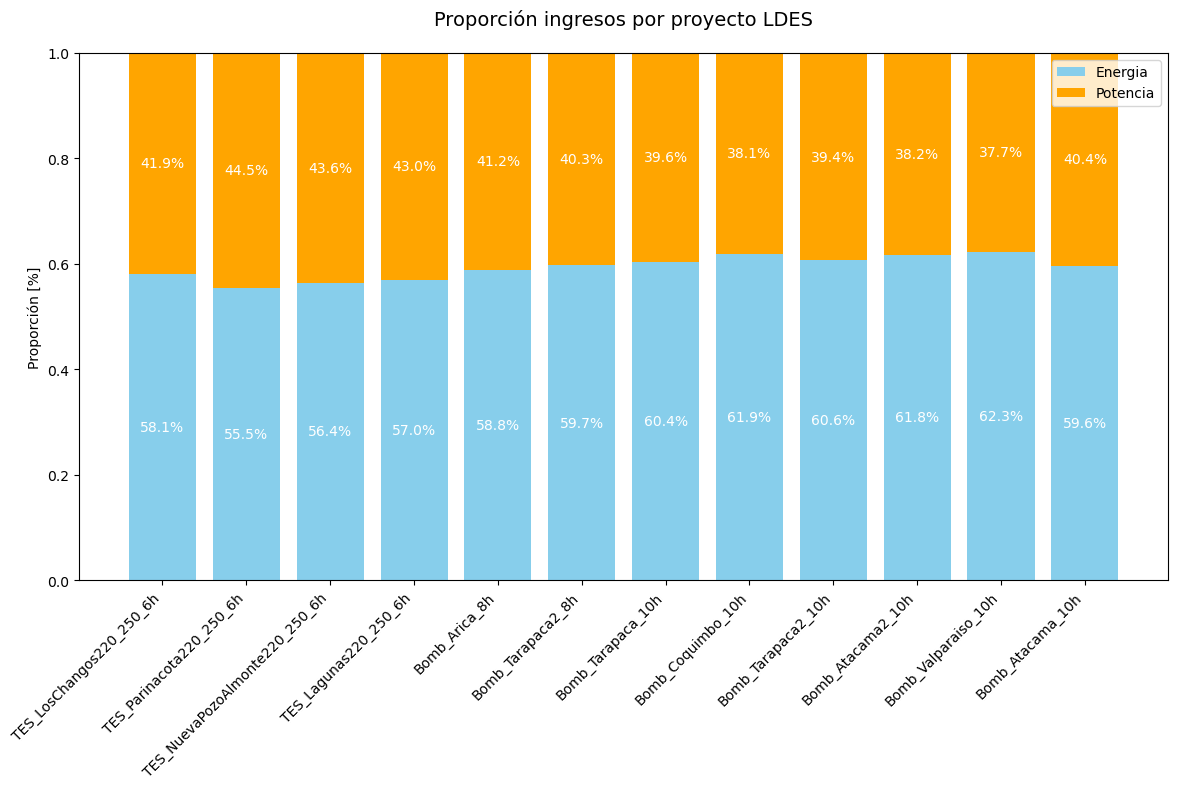

In [210]:
# Calculate total income and proportions
npv_df_tech_dur["total_income"] = npv_df_tech_dur["NPV_energy"] + npv_df_tech_dur["NPV_power"]
npv_df_tech_dur["energy_proportion"] = npv_df_tech_dur["NPV_energy"] / npv_df_tech_dur["total_income"]
npv_df_tech_dur["power_proportion"] = npv_df_tech_dur["NPV_power"] / npv_df_tech_dur["total_income"]

# Plot stacked bar chart
fig, ax = plt.subplots(figsize=(12, 8))

# Plot each income's proportion as a stacked bar
ax.bar(
    npv_df_tech_dur["generation_project"],
    npv_df_tech_dur["energy_proportion"],
    label="Energia",
    color="skyblue",
)
ax.bar(
    npv_df_tech_dur["generation_project"],
    npv_df_tech_dur["power_proportion"],
    bottom=npv_df_tech_dur["energy_proportion"],
    label="Potencia",
    color="orange",
)

for i, project in enumerate(npv_df_tech_dur["generation_project"]):
    ax.text(
        i,
        0.5 * npv_df_tech_dur["energy_proportion"].iloc[i],
        f"{npv_df_tech_dur['energy_proportion'].iloc[i]:.1%}",
        ha="center",
        va="center",
        color="white",
    )
    ax.text(
        i,
        npv_df_tech_dur["energy_proportion"].iloc[i] + 0.5 * npv_df_tech_dur["power_proportion"].iloc[i],
        f"{npv_df_tech_dur['power_proportion'].iloc[i]:.1%}",
        ha="center",
        va="center",
        color="white",
    )

# Customize the chart
ax.set_title("Proporción ingresos por proyecto LDES", fontsize=14 ,pad=20)
ax.set_ylabel("Proporción [%]")
ax.set_ylim(0, 1)
ax.legend(loc="upper right")

plt.xticks(rotation=45, ha="right")  # Adjust the angle and alignment
plt.tight_layout()
plt.show()


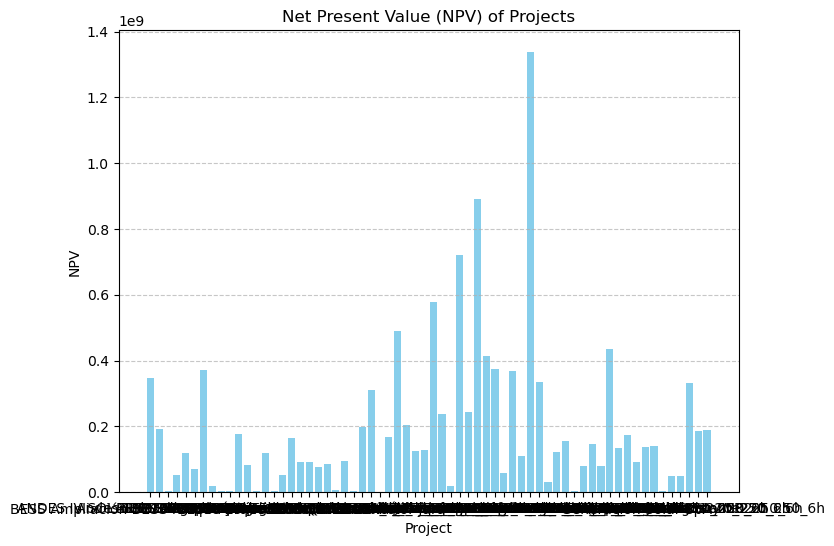

In [211]:
# Step 4: Plot the results
plt.figure(figsize=(8, 6))
plt.bar(npv_df['generation_project'], npv_df['NPV'], color='skyblue')
plt.title('Net Present Value (NPV) of Projects')
plt.xlabel('Project')
plt.ylabel('NPV')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

C:\Users\Ignac\AppData\Local\Temp\ipykernel_17480\3749007395.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gen_build_data_filtered["BuildGen"] = gen_build_data_filtered["BuildGen"].astype(float)


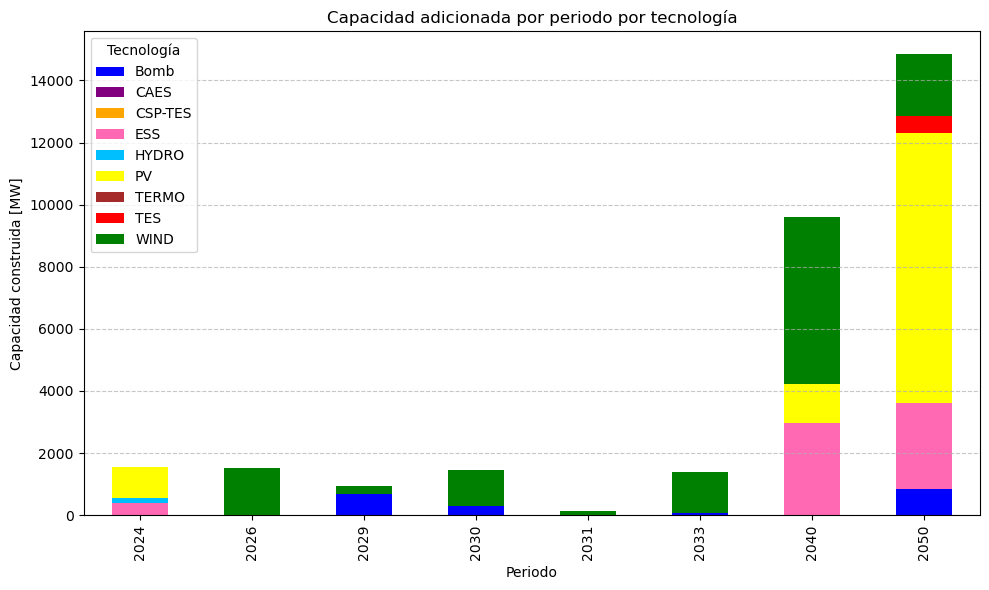

In [212]:
gen_build_data_filtered = gen_build_data[gen_build_data["BuildGen"] != '.']
gen_build_data_filtered["BuildGen"] = gen_build_data_filtered["BuildGen"].astype(float)
# Group by year and technology, summing constructed capacity
grouped_gen_build = gen_build_data_filtered.groupby(['PERIOD', 'gen_tech'])['BuildGen'].sum().reset_index()

# Pivot the data to have years as rows and technologies as columns
pivot_gen_build = grouped_gen_build.pivot(index='PERIOD', columns='gen_tech', values='BuildGen').fillna(0.0)

column_colors = [tech_colors.get(tech, 'gray') for tech in pivot_gen_build.columns]

# Plot
pivot_gen_build.plot(kind='bar', stacked=True, figsize=(10, 6), color=column_colors)
plt.title('Capacidad adicionada por periodo por tecnología')
plt.xlabel('Periodo')
plt.ylabel('Capacidad construida [MW]')
plt.legend(title='Tecnología')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

C:\Users\Ignac\AppData\Local\Temp\ipykernel_17480\142577499.py:14: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.stripplot(


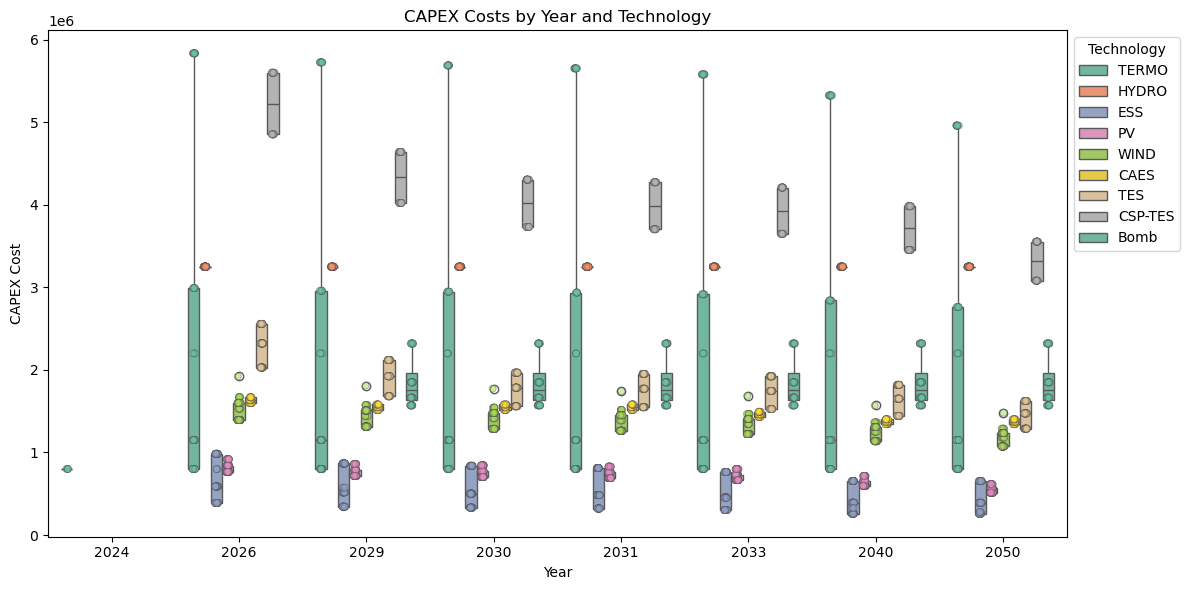

C:\Users\Ignac\AppData\Local\Temp\ipykernel_17480\142577499.py:44: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.stripplot(


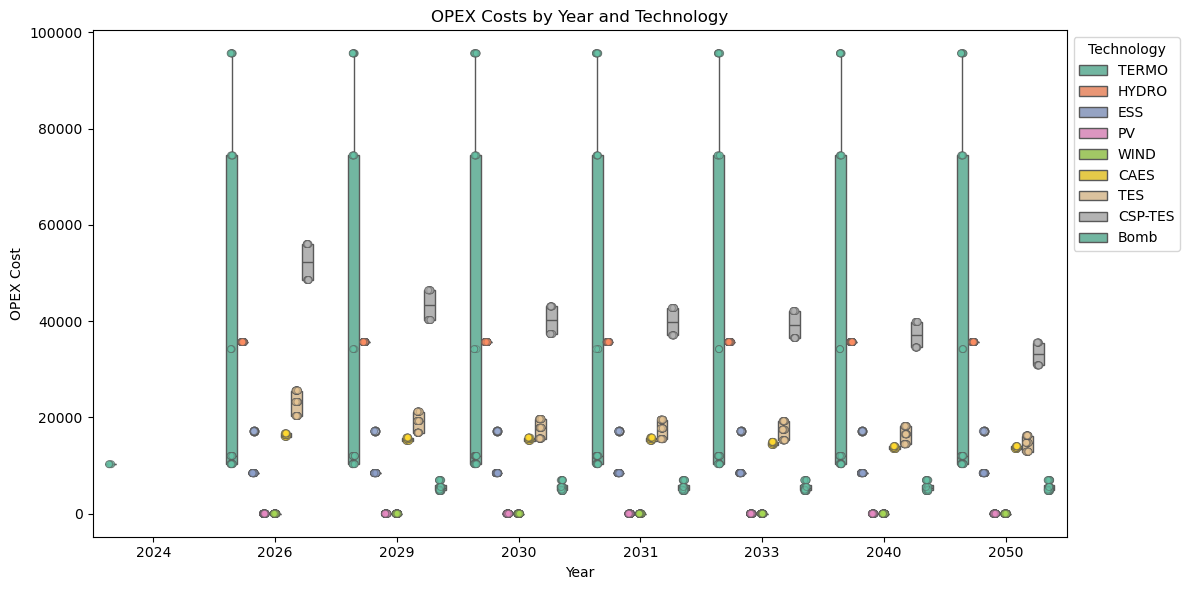

In [213]:
df_merge_cost_build_and_gen_tech = pd.merge(filtered_cost, gen_info_data[["GENERATION_PROJECT", "gen_tech"]], on='GENERATION_PROJECT', how='inner')


# Plot for CAPEX
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=df_merge_cost_build_and_gen_tech,
    x="PERIOD",
    y="gen_overnight_cost",
    hue="gen_tech",
    palette="Set2",
    dodge=True,
)
sns.stripplot(
    data=df_merge_cost_build_and_gen_tech,
    x="PERIOD",
    y="gen_overnight_cost",
    hue="gen_tech",
    palette="Set2",
    dodge=True,
    alpha=0.5,
    linewidth=0.6,
    edgecolor="gray",
    legend=False,
)

plt.title("CAPEX Costs by Year and Technology")
plt.xlabel("Year")
plt.ylabel("CAPEX Cost")
plt.legend(title="Technology", loc="upper left", bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

# Plot for OPEX
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=df_merge_cost_build_and_gen_tech,
    x="PERIOD",
    y="gen_fixed_om",
    hue="gen_tech",
    palette="Set2",
    dodge=True,
)
sns.stripplot(
    data=df_merge_cost_build_and_gen_tech,
    x="PERIOD",
    y="gen_fixed_om",
    hue="gen_tech",
    palette="Set2",
    dodge=True,
    alpha=0.5,
    linewidth=0.6,
    edgecolor="gray",
    legend=False,
)

plt.title("OPEX Costs by Year and Technology")
plt.xlabel("Year")
plt.ylabel("OPEX Cost")
plt.legend(title="Technology", loc="upper left", bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()